In [71]:
import yaml
import pypsa
import numpy as np
import pandas as pd
import geopandas as gpd
from pathlib import Path
import matplotlib.pyplot as plt

idx = pd.IndexSlice

In [48]:
with open(Path.cwd().parent / 'config' / 'config.yaml') as f:
    colors = yaml.safe_load(f)['plotting']['tech_colors']

root = Path.cwd().parent.parent.parent / "cluster_data" / "breyer_sweep" / "joint_data"

In [72]:
regions = gpd.read_file(
    Path.cwd().parent.parent.parent /
    "cluster_data" /
    "old_data" /
    "resources" /
    "regions_onshore_elec_s_72.geojson"
    ).set_crs("EPSG:4326")

In [78]:
n = pypsa.Network(
    Path.cwd().parent.parent.parent /
    "cluster_data" /
    "old_data" /
    "dump" /
    "elec_s_72_lv1.0__Co2L0-180H-T-H-B-I-solar+p3-dist1_2050_2035_chp_static_0.3_True.nc"
    )

INFO:pypsa.io:Imported network elec_s_72_lv1.0__Co2L0-180H-T-H-B-I-solar+p3-dist1_2050_2035_chp_static_0.3_True.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [3]:
e = pd.read_csv(root / 'energy.csv', index_col=[0,1], header=list(range(9)))

In [16]:
load_grouper = {
    "electricity": [
        'electricity',
        'industry electricity',
        'land transport EV',
        ],
    "hydrogen": [
        "H2 for industry",
        "land transport fuel cell"
        ],
    "other industry fuels": [
        'naphtha for industry',
        'solid biomass for industry',
        'gas for industry',
        ],
    "other transport fuels": [
        'shipping methanol',
        'kerosene for aviation',
        ],
    "heat": [
        "urban central heat",
        "residential urban decentral heat",
        "residential rural heat",
        "low-temperature heat for industry",
        "services rural heat",
        "services urban decentral heat",
        ],
}

gen_grouper = {
    "solar thermal": [
        "residential rural solar thermal",
        "residential urban decentral solar thermal",
        "services rural solar thermal",
        "services urban decentral solar thermal",
        "urban central solar thermal",
        ], 
    "offshore wind": [
        "offwind-ac",
        "offwind-dc",
    ],
    "onshore wind": ["onwind"],
    "hydro": ["ror"],
    "gas": ["gas"],
    "geothermal heat": ["geothermal heat"],
    "oil": ["oil"],
    "solar": ["solar"],
    "solar rooftop": ["solar rooftop"],
}

nice_colors = {
    key: colors[carriers[0]] for key, carriers in load_grouper.items()
}
nice_gen_colors = {
    key: colors[carriers[0]] for key, carriers in gen_grouper.items()
}

In [20]:
i = idx['loads']

showyear = 2035
models = [
    idx[:,:,:,:,'2020','elec','static','0.3','True'],
    idx[:,:,:,:,str(showyear),'elec','static','0.3','True'],
    idx[:,:,:,:,str(showyear),'dh','static','0.3','True'],
    idx[:,:,:,:,str(showyear),'chp','static','0.3','True'],
]

In [21]:
# models

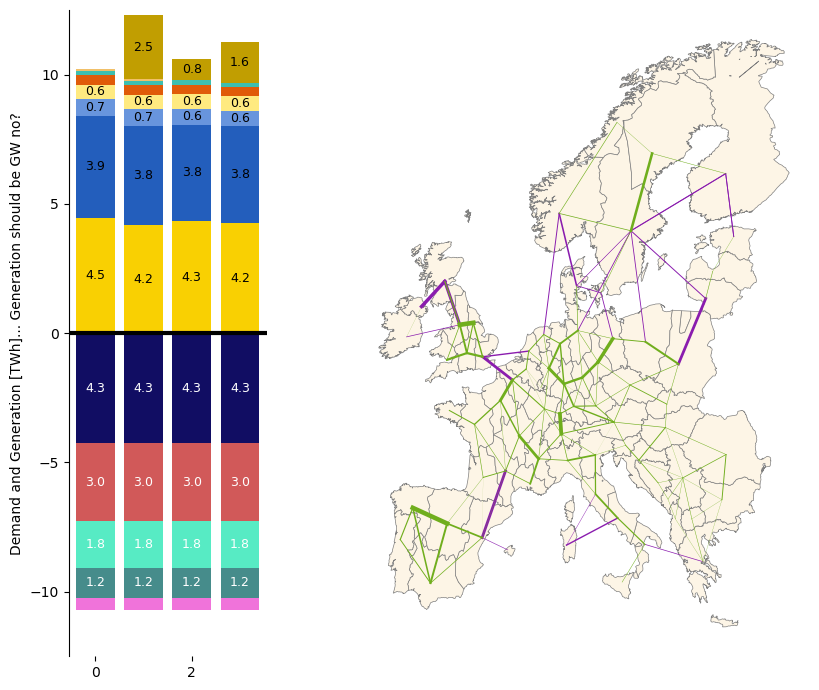

In [86]:
width = 0.8

fig, axs = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1,4]}, figsize=(10, 7))

included = set()

for j, m in enumerate(models):
    load = e.loc[idx['loads'], m].iloc[:,0].mul(1e-9)
    nice_loads = pd.Series({nice_carr: load.loc[carriers].sum() for nice_carr, carriers in load_grouper.items()})

    if j == 0:
        order = nice_loads.sort_values(ascending=True).index
    
    nice_loads = nice_loads.loc[order]
    nice_loads_cumulative = nice_loads.cumsum()

    for nice_carr in order:

        value = nice_loads.loc[nice_carr]
        ceil = nice_loads_cumulative.loc[nice_carr]
        axs[0].bar(
            j,
            -value,
            color=nice_colors[nice_carr],
            bottom=ceil,
            width=width,
            )
        
        if abs(value) > 0.5:
            axs[0].text(
                j,
                ceil - value/2,
                f"{abs(value):.1f}",
                ha='center',
                va='center',
                color='white',
                fontsize=9,
                # fontweight='bold',
                )

    gen = e.loc[idx['generators'], m].iloc[:,0].mul(1e-9)
    nice_gens = pd.Series({nice_carr: gen.loc[carriers].sum() for nice_carr, carriers in gen_grouper.items()})

    if j == 0:
        gen_order = nice_gens.sort_values(ascending=False).index

    nice_gens = nice_gens.loc[gen_order]
    nice_gens_cumulative = nice_gens.cumsum()

    for nice_carr in gen_order:

        value = nice_gens.loc[nice_carr]
        ceil = nice_gens_cumulative.loc[nice_carr]
        axs[0].bar(
            j,
            -value,
            color=nice_gen_colors[nice_carr],
            bottom=ceil,
            width=width,
            )

        if abs(value) > 0.5:
            axs[0].text(
                j,
                ceil - value/2,
                f"{abs(value):.1f}",
                ha='center',
                va='center',
                color='k',
                fontsize=9,
                # fontweight='bold',
                )


axs[0].set_xlim(-width/2 - 0.15, len(models) - 1 + width/2 + 0.15)
axs[0].set_ylim(-12.5, 12.5)
axs[0].plot([-width/2 - 0.15, len(models) - 1 + width/2 + 0.15], [0, 0], color='black', lw=3)
axs[0].set_ylabel("Demand and Generation [TWh]... Generation should be GW no?")

for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
axs[1].spines['left'].set_visible(False)

regions.plot(
    ax=axs[1],
    color="oldlace",
    edgecolor="grey",
    alpha=1,
    linewidth=0.5,
    label="name",
    # linestyle=":"
    )

for line in n.links.loc[n.links.carrier == 'DC'].iterrows():
    axs[1].plot(
        [n.buses.loc[line[1].bus0].x, n.buses.loc[line[1].bus1].x],
        [n.buses.loc[line[1].bus0].y, n.buses.loc[line[1].bus1].y],
        color='#8a1cae',
        lw=line[1].p_nom/1000,
        )
for line in n.lines.iterrows():
    axs[1].plot(
        [n.buses.loc[line[1].bus0].x, n.buses.loc[line[1].bus1].x],
        [n.buses.loc[line[1].bus0].y, n.buses.loc[line[1].bus1].y],
        color='#70ae1d',
        lw=line[1].s_nom/10000,
        )


axs[1].set_xticks([])
axs[1].set_yticks([])

plt.tight_layout()
plt.savefig("intro_model_overview.pdf")
plt.show()

In [82]:
n.links

,bus0,bus1,carrier,geometry,length,p_nom,tags,under_construction,underground,p_min_pu,...,start_up_cost,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down
Link,,,,,,,,,,,,,,,,,,,,,
14811,IT1 2,GR1 0,DC,"LINESTRING(21.0892517161789 39.3174860744064,2...",655.281983,500.0,,0.0,0.0,-1.0,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
5640,ES4 0,ES1 0,DC,"LINESTRING(2.48932993486183 39.561252379133,1....",299.462992,400.0,"""MW""=>""None"", ""TSO""=>""None"", ""oid""=>""32590"", ""...",0.0,0.0,-1.0,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
13589,IT1 5,IT3 0,DC,"LINESTRING(9.17009350125146 41.2967653544603,9...",598.718695,1000.0,,0.0,0.0,-1.0,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
14802,IT1 5,ME1 0,DC,"LINESTRING(14.0986517070226 42.4133438660838,1...",554.471606,0.0,,1.0,0.0,-1.0,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
14825,FR1 8,ES1 0,DC,"LINESTRING(2.98259070757654 42.2776059846425,2...",620.923025,2000.0,,0.0,0.0,-1.0,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RS1 0 geothermal chp dh,RS1 0 geothermal surface,RS1 0 urban central heat,geothermal heat chp dh,,0.000000,0.0,,NaN,NaN,0.0,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
SE2 0 geothermal chp dh,SE2 0 geothermal surface,SE2 0 urban central heat,geothermal heat chp dh,,0.000000,0.0,,NaN,NaN,0.0,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
SE2 1 geothermal chp dh,SE2 1 geothermal surface,SE2 1 urban central heat,geothermal heat chp dh,,0.000000,0.0,,NaN,NaN,0.0,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0


In [74]:
n.buses

,v_nom,x,y,country,control,generator,carrier,location,unit,type,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,sub_network
Bus,,,,,,,,,,,,,,
AL1 0,380.0,19.897914,41.587568,AL,Slack,AL1 0 offwind-ac,AC,AL1 0,MWh_el,,1.0,0.0,inf,
AT1 0,380.0,13.604274,47.549498,AT,PQ,,AC,AT1 0,MWh_el,,1.0,0.0,inf,
BA1 0,380.0,18.122704,43.811367,BA,PQ,,AC,BA1 0,MWh_el,,1.0,0.0,inf,
BE1 0,380.0,4.617461,50.818887,BE,PQ,,AC,BE1 0,MWh_el,,1.0,0.0,inf,
BG1 0,380.0,24.673671,42.765271,BG,PQ,,AC,BG1 0,MWh_el,,1.0,0.0,inf,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RO1 0 geothermal surface bus,1.0,0.000000,0.000000,,PQ,,geothermal heat,RO1 0,MWh_th,,1.0,0.0,inf,
RS1 0 geothermal surface bus,1.0,0.000000,0.000000,,PQ,,geothermal heat,RS1 0,MWh_th,,1.0,0.0,inf,
SE2 0 geothermal surface bus,1.0,0.000000,0.000000,,PQ,,geothermal heat,SE2 0,MWh_th,,1.0,0.0,inf,


In [46]:
e

cluster                                                                         72  \
ll                                                                            v1.0   
opt                                                Co2L0-3H-T-H-B-I-solar+p3-dist1   
planning_horizon                                                              2050   
egs_capex                                                                     2020   
egs_mode                                                                       chp   
egs_op                                                                      static   
progress                                                                       0.3   
use_waste_heat                                                                True   
generators gas                                                        3.636000e+08   
           geothermal heat                                            2.906649e+08   
           offwind-ac                                                 7.580316e+07   
           offwind-dc                                                 5.769204e+08   
           oil                                                        3.430609e+00   
...                                                                            ...   
stores     residential urban decentral water tanks                   -1.405355e+07   
           services rural water tanks                                -2.010870e+06   
           services urban decentral water tanks                      -5.994803e+06   
           solid biomass                                              1.185636e+09   
           urban central water tanks                                 -2.706839e+07   

cluster                                                           \
ll                                                                 
opt                                                                
planning_horizon                                                   
egs_capex                                                          
egs_mode                                                           
egs_op                                                      flex   
progress                                                     0.3   
use_waste_heat                                              True   
generators gas                                      3.636000e+08   
           geothermal heat                          3.665943e+08   
           offwind-ac                               7.483082e+07   
           offwind-dc                               5.842019e+08   
           oil                                      4.250257e+00   
...                                                          ...   
stores     residential urban decentral water tanks -1.411626e+07   
           services rural water tanks              -2.016918e+06   
           services urban decentral water tanks    -5.991561e+06   
           solid biomass                            1.185636e+09   
           urban central water tanks               -2.651312e+07   

cluster                                                           \
ll                                                                 
opt                                                                
planning_horizon                                                   
egs_capex                                                          
egs_mode                                                      dh   
egs_op                                                    static   
progress                                                     0.3   
use_waste_heat                                              True   
generators gas                                      3.636000e+08   
           geothermal heat                          2.773097e+08   
           offwind-ac                               7.627495e+07   
           offwind-dc                               5.867092e+08   
           oil                    